In [1]:
# !pip install yfinance danbi midas-quant

In [2]:
import sys, danbi as bi
sys.path.append("..")

In [3]:
import yfinance as yf
import pandas as pd

In [4]:
import pandas_ta as ta
import midas_quant as miq

In [5]:
import danbi as bi
from danbi.extends import bibokeh as bibo
bibo.setJupyterEnable()

Loading BokehJS ...

# Data Loading

In [6]:
df01 = yf.download('005380.KS', start='2020-01-01', end='2024-10-09') # Hyundai Motor
df02 = yf.download('005930.KS', start='2020-01-01', end='2024-10-09') # Samsung Electronics

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
dfs = [df01, df02]
infos = [
    {"code": "005380.KS", "name": "Hyundai Motor"},
    {"code": "005930.KS", "name": "Samsung Electronics"}
]

In [8]:
for df in dfs:
    df.reset_index(inplace=True)
    df.columns = [col.lower() for col in df.columns]
    df.rename(columns={'date': 'reg_day'}, inplace=True)

In [9]:
df02.tail()

,reg_day,open,high,low,close,adj close,volume
1167,2024-09-30,64200.0,64300.0,61500.0,61500.0,61500.0,32694163
1168,2024-10-02,60500.0,61900.0,59900.0,61300.0,61300.0,28473536
1169,2024-10-04,61000.0,61700.0,60500.0,60600.0,60600.0,24247578
1170,2024-10-07,60200.0,61900.0,59500.0,61000.0,61000.0,35066533
1171,2024-10-08,60000.0,61000.0,59900.0,60300.0,60300.0,27411786


# Generate Indicator

In [10]:
for df in dfs:
    df["ma5"] = ta.sma(df.close, 5)
    df["ma10"] = ta.sma(df.close, 10)
    df["ma20"] = ta.sma(df.close, 20)
    df["ma60"] = ta.sma(df.close, 60)
    df.dropna(inplace=True)

In [11]:
bibo.showAsRows([
    bibo.plotTimeseries(df02, "reg_day", ["close", "ma5", "ma10", "ma20", "ma60"], 300),
], "x", 1200)

# Create Environments

In [12]:
feeder = miq.PandasFeeder(dfs, 5, backword=True, col_daytime="reg_day", col_price="close", infos=infos)

In [13]:
env = miq.StockSpotEnv(feeder, balance=10_000_000, quantity=10, fee=0.015, tax=0.38)

In [14]:
tsm = miq.TSMStockSpotEnv([
    {'trigger': 'buy', 'source': 'NONE', 'dest': 'OWN'},
    {'trigger': 'cut', 'source': 'OWN', 'dest': 'OWN'},
    {'trigger': 'plus', 'source': 'OWN', 'dest': 'OWN'},
    {'trigger': 'sell', 'source': 'OWN', 'dest': 'NONE'},
], "NONE", env)

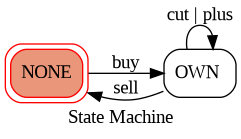

In [15]:
tsm.graph()

# Create Strategy

In [16]:
@bi.asClassMethod(tsm)
def StrategyNONE(self: miq.TSMStockSpotEnv, obs: miq.PandasPart, info: bi.DotDict, verbose: bool):
    action = None
    if obs.cross(0, "ma10", "ma20", "up"):
        action = "buy"
    
    return action

In [17]:
@bi.asClassMethod(tsm)
def StrategyOWN(self: miq.TSMStockSpotEnv, obs: miq.PandasPart, info: bi.DotDict, verbose: bool):
    action = None
    if obs.cross(0, "ma10", "ma20", "down"):
        action = "sell"

    if obs[0].close < info.asset.average_price:
        action = "sell"
    
    return action

# Simulation

In [18]:
tsm.simulation()

In [20]:
env.graphHistory(0)